In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from cycler import cycler
import sys
import os
pdir = os.getcwd() # project directory relative to the one of this script
sys.path.insert(0,os.path.join(pdir,'.'))

%matplotlib inline
color_cycle = cycler('color',['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999','#ffff33'])
mpl.rc('figure',figsize=[2.7,1.6])
mpl.rc('font',size=8.0)
#mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rc('lines',linewidth=0.7) 
mpl.rc('axes',prop_cycle=color_cycle,grid=True,linewidth=0.5,axisbelow=True,unicode_minus=False)
mpl.rc('grid',linewidth=0.3,linestyle=':')
mpl.rc('legend',fontsize='medium',framealpha=1.0,numpoints=1)
mpl.rc('svg',fonttype='none')
mpl.rc('savefig',dpi=300)
import numpy as np
import h5py
sys.path.append('/home/flo/cfs/CFS/share/python/')
from hdf5_tools import *
from glob import glob
from numpy import pi

In [2]:
simpath = pdir
jobname = 'test'
h5 = h5py.File(simpath+'/results_hdf5/%s.cfs'%jobname)
try :
    # results
    r = {}
    for result in ['magFluxDensity','magEddyCurrentDensity','magTotalCurrentDensity',\
                   'heatFluxDensity','magPotential','magCoilCurrentDensity']:
        resultList = []
        for i in [1,2,3]:
            resultList.append( get_result(h5,result,'V%i'%i,step='all',multistep=1) )
        if (len(resultList[0].shape)<=2):
            resultList = [np.array([res]) for res in resultList]
        r[result] = np.hstack(resultList)
            
    # scalar results
    for result in ['heatTemperature','magJouleLossPowerDensity']:
        resultList = []
        for i in [1,2,3]:
            resultList.append( get_result(h5,result,'V%i'%i,step='all',multistep=1) )
        if (len(resultList[0].shape)<=1):
            resultList = [np.array([res]) for res in resultList]
        r[result] = np.hstack(resultList)
    vol = np.hstack([ get_result(h5,'volume','V%i'%i,multistep=0) for i in [1,2,3]])
    cent = np.vstack([ get_centroids(h5,'V%i'%i) for i in [1,2,3]])
    coord = np.vstack([ get_coordinates(h5,'V%i'%i) for i in [1,2,3]])
    f = get_step_values(h5)[-1]
except Exception as e:
        h5.close()
        print(e)

In [3]:
# model parameters
a = 1.0 # width
b1 = 1.0 # heights
b2 = 1.0
b3 = b1
yb = np.cumsum([0,b1,b2,b3])-b1/2
#b = np.array([0,b1,b2,b3])
c = 1.0 # thickness
w = 2*pi*np.linspace(1e-6,f[-1])
gamma0 = 1e4 # coil
mu = 1.2566E-04 # core
alpha = 1e-4

Y = c/(mu*a)*(b1+b3)/(b1*b3) + 1j * w * gamma0 * c*b2/a
Z = 1/Y

I = np.ones_like(w)#1.0 # excitation current

Phi = Z*I
U = 1j*w*Phi
B1 = Phi/(a*b1)

Phi,np.angle(Z)/pi*180
#fig,ax=plt.subplots()
#ax.plot(w,np.angle(Z))
#ax.plot(w,np.angle(U/I))
#ax.plot(w,np.cos(np.angle(Z)))
#ax.plot(w,np.cos(np.angle(U/I)))
#ax.set_yticks([0,pi/4,pi/2])

#fig,ax=plt.subplots()
#ax.plot(w,np.abs(B1))

P = (I.real*U.real + I.imag*U.imag)*1/2 # factor 2 because we have 2 coils


# final temperature
# heat balance, assume symmetry 
Qin = P
# Qout = 2*alpha*Te = Qin
Te = Qin/(2*alpha)

# temperature in the center is dependent on the heat transfer in b1,b3
# Qin/2 = A*k*dT/l = a*c*k*dT/b # assume symmetry
k = 1
dT1 = Qin/2*b1/(k*a*c)
# because k is large in the center, the distribution is (almost) constant there

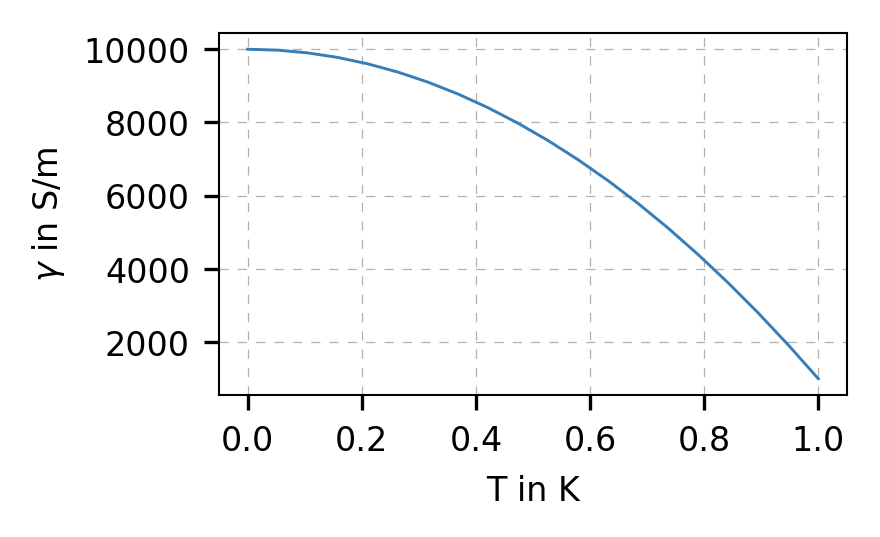

In [4]:
# solve a non-linear problem with gamma(T)
gamma1 = 1000
gamma = lambda x: gamma0 - (gamma0-gamma1)*x**2
Tp = np.linspace(0,1,20)
fig,ax=plt.subplots()
ax.plot(Tp,gamma(Tp))
np.savetxt('ElecCond.fnc',np.vstack([Tp,gamma(Tp)]).T)
ax.set_ylabel('$\gamma$ in S/m')
ax.set_xlabel('T in K')

# define function for heat balance (T = approx temperature in the center)
def Pfnc(T,w=1):
    Y = c/(mu*a)*(b1+b3)/(b1*b3) + 1j * w * gamma(T) * c*b2/a
    Z = 1/Y
    Phi = Z*I[0]
    U = 1j*w*Phi
    P = (I[0].real*U.real + I[0].imag*U.imag)*1/2
    return P
def Tfnc(P):
    Qin = P
    Te = Qin/(2*alpha)
    dT1 = Qin/2*b1/(k*a*c)
    return Te+dT1
x = 1
#P(0,0)
from scipy.optimize import bisect
Tnl = np.zeros_like(w)
for i in range(len(w)):
    Tnl[i] = bisect(lambda x: Tfnc(Pfnc(x,w=w[i]))-x,0,1)

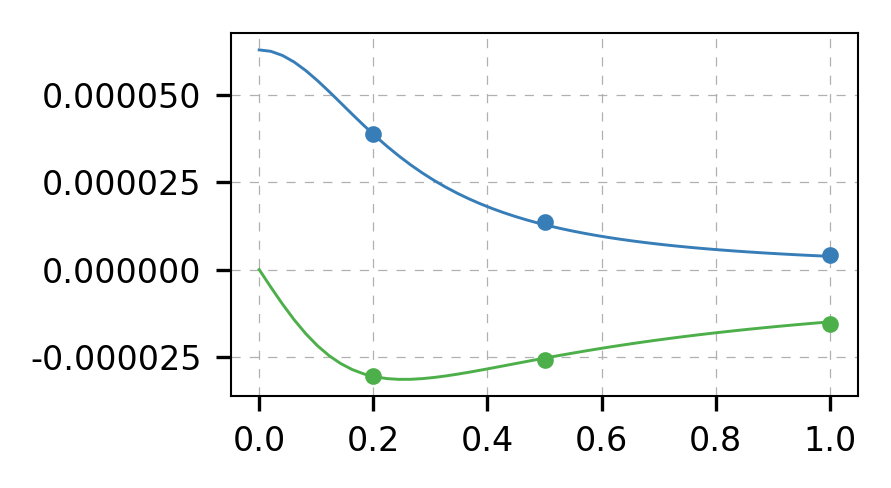

In [5]:
# Flux
data = np.loadtxt(simpath+'/history/%s-magFlux-surfRegion-S1T.hist'%jobname)
PhiCfs = data[:,1]*np.exp(1j*data[:,2]*pi/180)

fig,ax=plt.subplots()
l, = ax.plot(w/2/pi,Phi.real)
ax.plot(data[:,0],PhiCfs.real,'.',color=l.get_color())
l, = ax.plot(w/2/pi,Phi.imag)
ax.plot(data[:,0],PhiCfs.imag,'.',color=l.get_color())

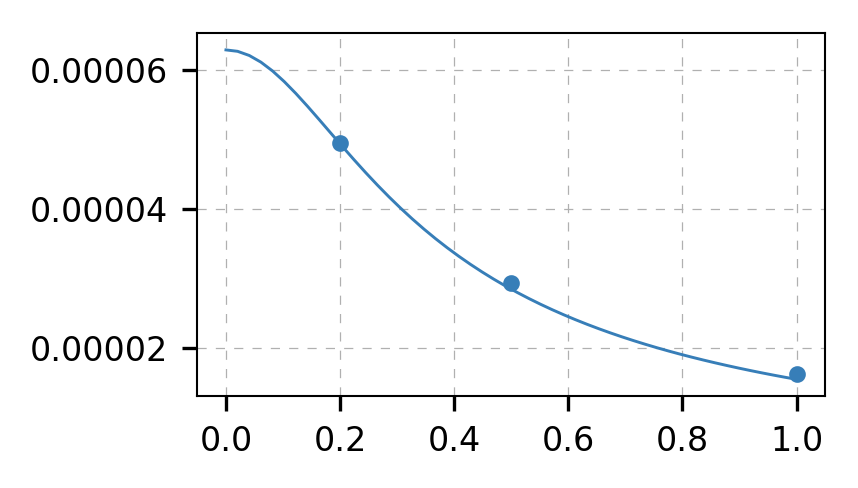

In [6]:
# flux density
fig,ax=plt.subplots()
l, = ax.plot(w/2/pi,np.abs(Phi)/(a*b1))
ax.plot(f,np.max(np.linalg.norm(r['magFluxDensity'],axis=-1),axis=-1),'.',color=l.get_color())


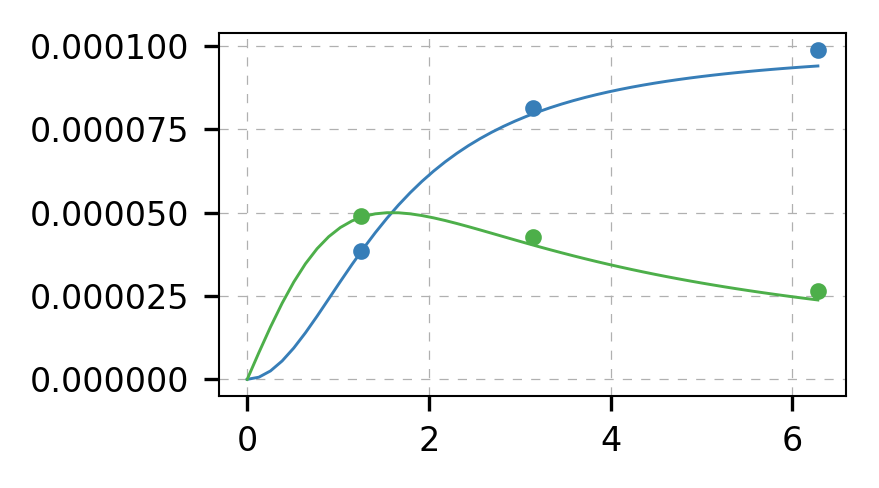

In [7]:
# Voltage
data = np.loadtxt(simpath+'/history/%s-coilInducedVoltage-coil-coil.hist'%jobname)
UCfs = data[:,1]*np.exp(1j*data[:,2]*pi/180)

fig,ax=plt.subplots()
l, = ax.plot(w,U.real)
ax.plot(data[:,0]*2*pi,UCfs.real,'.',color=l.get_color())
l, = ax.plot(w,U.imag)
ax.plot(data[:,0]*2*pi,UCfs.imag,'.',color=l.get_color())

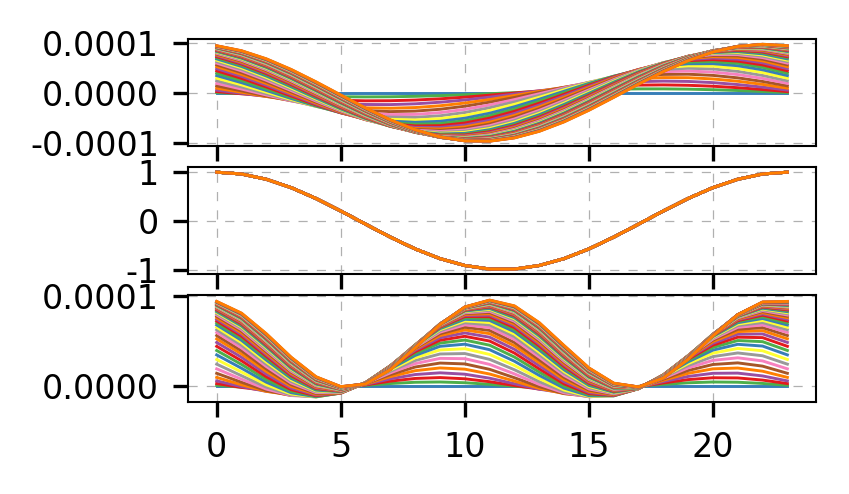

In [8]:
t = np.linspace(0,1,24)
t = np.outer(t,2*pi/w)#.T.shape
#fig,ax=plt.subplots()
#ax.plot( (U*np.outer(t,2*pi/w)).real.T )
Exp = np.exp(1j*w*t)#.shape
fig,axs=plt.subplots(nrows=3)
axs[0].plot((U*Exp).real)
axs[1].plot((I*Exp).real)
axs[2].plot((U*Exp).real*(I*Exp).real);

#ax.set_xlim(0,t[-1,-1])

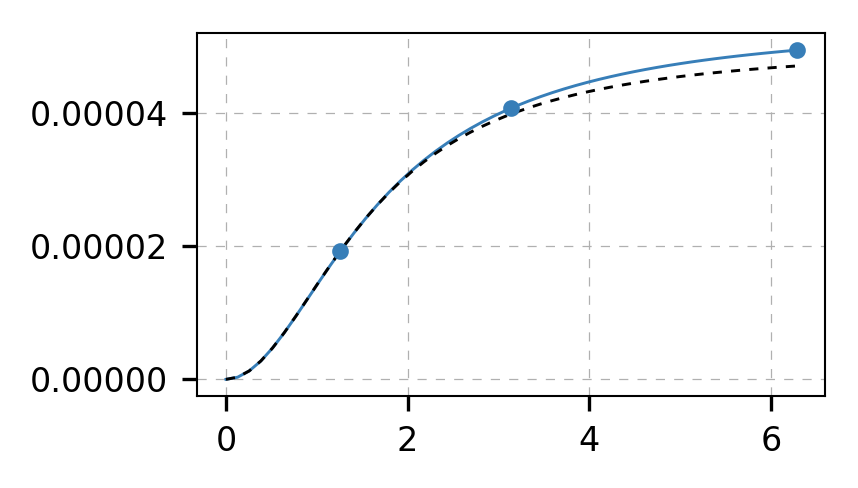

In [9]:
# integrate the time signal
Eint = np.trapz(((U*Exp).real*(I*Exp).real),t,axis=0)
fig,ax=plt.subplots()
#ax.plot(w,Eint)
l, = ax.plot(w,[Pfnc(Tnl[i],w[i]) for i in range(len(w))])#/(np.abs(U)*np.abs(I)*np.cos(np.angle(Z))/2))
ax.plot(w,Eint/(2*pi/w),':k')
ax.plot(2*pi*f,np.sum(r['magJouleLossPowerDensity'].real*vol,axis=-1),'.',color=l.get_color())

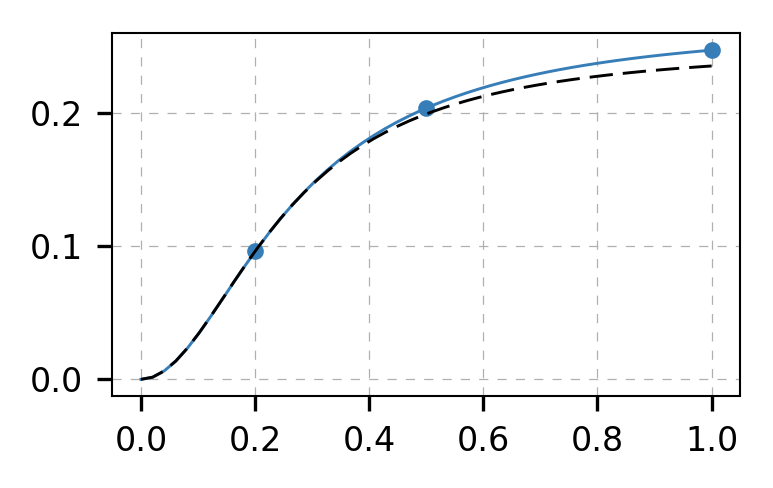

In [10]:
# temperature maximum
fig,ax=plt.subplots()

l, = ax.plot(w/2/pi,Tnl)
ax.plot(f,np.max(np.abs(r['heatTemperature']),axis=-1),'.',color=l.get_color())

ax.plot(w/2/pi,Te+dT1,'--k',label='linear')

#l, = ax.plot(w/2/pi,Te+dT1,label='linear')
#ax.plot(f,np.max(np.abs(r['heatTemperature']),axis=-1),'.',color=l.get_color())
#ax.plot(w/2/pi,Tnl)

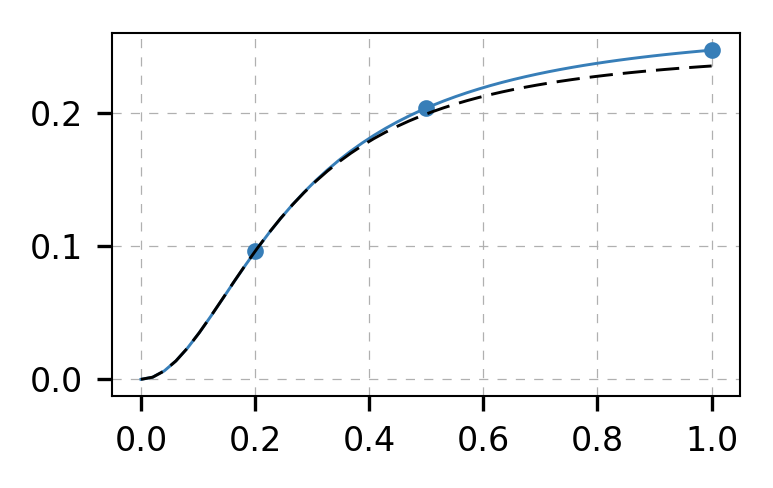

In [11]:
# temperature minimum (at end)
fig,ax=plt.subplots()

l, = ax.plot(w/2/pi,Tnl)
ax.plot(f,np.min(np.abs(r['heatTemperature']),axis=-1),'.',color=l.get_color())

ax.plot(w/2/pi,Te,'--k',label='linear')

## Field Solutions

In [12]:
# elements
Ne = np.argsort(cent[:,1]) # sort by y
Ie = cent[Ne,2]>=0
Ne = Ne[Ie]
# frequency
Nf = np.arange(len(f))
#nodes
Nn = np.argsort(coord[:,1])#[In]
In = np.logical_and(coord[Nn,0]>0,coord[Nn,2]>0)
Nn = Nn[In]

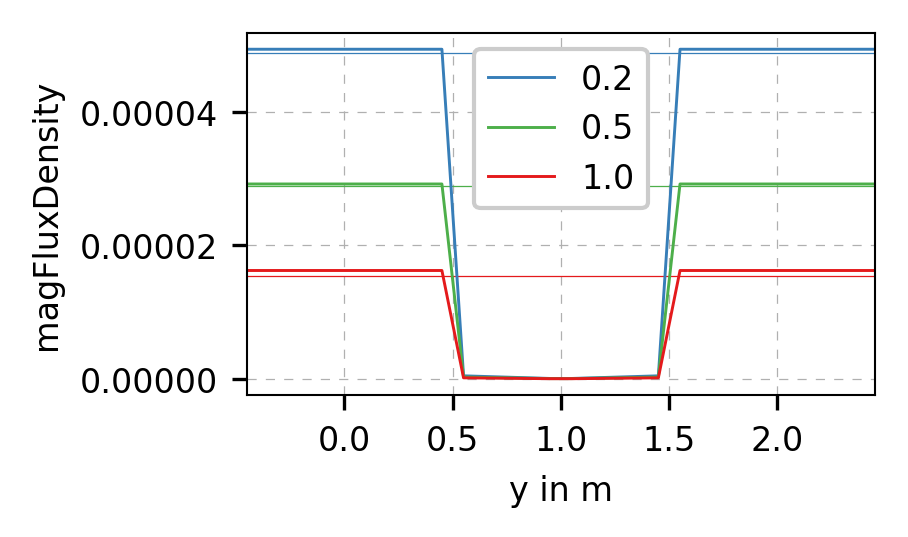

In [13]:
fig,ax = plt.subplots()
for result in ['magFluxDensity']:
    for n in Nf:
        y = r[result][n,Ne,2]
        i = np.argmin(np.abs(w/2/pi-f[n]))
        l, = ax.plot(cent[Ne,1],np.abs(y),label=f[n])
        ax.set_xlim(cent[Ne[0],1],cent[Ne[-1],1])
        ax.hlines(np.abs(Phi[i]/(a*b1)),*ax.get_xlim(),lw=0.3,color=l.get_color())
    ax.set_xlabel('y in m')
    ax.set_ylabel(result)
    ax.legend()

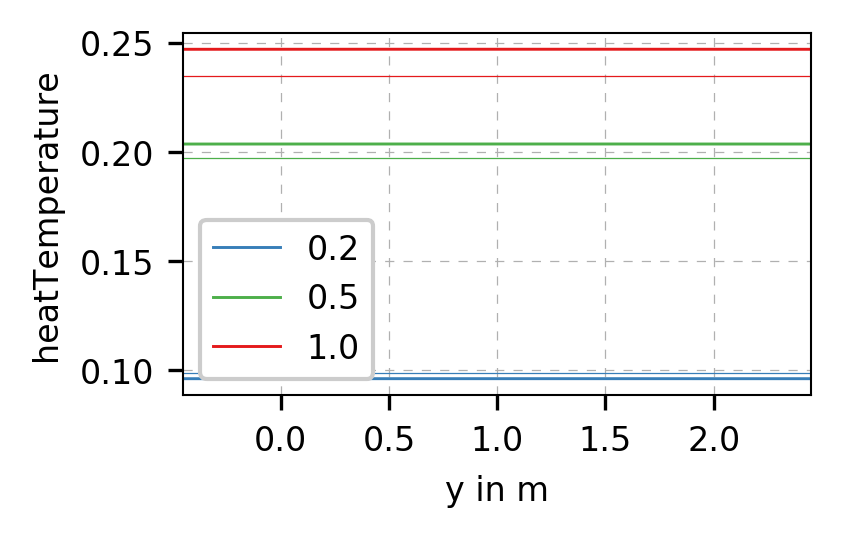

In [14]:
fig,ax = plt.subplots()
for result in ['heatTemperature']:
    for n in Nf:
        y = r[result][n,Nn]
        i = np.argmin(np.abs(w/2/pi-f[n]))
        l, = ax.plot(coord[Nn,1],np.abs(y),label=f[n])
        ax.set_xlim(cent[Ne[0],1],cent[Ne[-1],1])
        ax.hlines(np.abs(Te[i]+dT1[i]),*ax.get_xlim(),lw=0.3,color=l.get_color())
    ax.set_xlabel('y in m')
    ax.set_ylabel(result)
    ax.legend()